In [1]:
# choose experiment 1 or 2
expe_num = 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from statsmodels.stats.contingency_tables import Table2x2
from math import lgamma, exp, log
import math 
import cv2



In [3]:

def eval_situational(df, col):
    #  Evaluates string representations of Python objects in a DataFrame column.
    new_col = []
    
    for _, row in df.iterrows():
        val = row[col]
        
        if isinstance(val, str):
            try:
                new_val = eval(val) 
                new_val = new_val[0] if new_val else np.nan
            except:
                new_val = np.nan
        else:
            new_val = np.nan
        
        new_col.append(new_val) 
    return new_col

def eval_fun(df, col):
    return [eval(rt)[0] for rt in df[col]]

In [4]:
def clean_data(unclean_df):
    # Remove training trials that did not happen (i.e., where 'train_rt' is '[]')
    unclean_df = unclean_df[unclean_df['train_rt'].apply(lambda x: x != '[]')]
    
    # Separate rows where 'train_rt', 'trial_rt', and 'surprised_trial_rt' are not NaN
    train_rows = unclean_df[unclean_df['train_rt'].notna()]
    trial_rows = unclean_df[unclean_df['trial_rt'].notna()]
    surprise_rows = unclean_df[unclean_df['surprised_trial_rt'].notna()]
    
    # Extract reaction times (RT) for all relevant trials using eval_fun function
    relevant_rt = eval_fun(train_rows, 'train_rt') + eval_fun(trial_rows, 'trial_rt') + eval_fun(surprise_rows, 'surprised_trial_rt')
    
    # Extract success indicators for all relevant trials
    relevant_success = eval_fun(train_rows, 'train_success') + eval_fun(trial_rows, 'trial_success') + eval_fun(surprise_rows, 'surprised_trial_success')
    
    # Process additional relevant columns for 'surprise' phase
    # Extract 'surprised_irrelevant_rt' and 'surprised_trial_success' using eval_fun
    surprise_rows.loc[:, 'surprised_irrelevant_rt'] = eval_fun(surprise_rows, 'surprised_irrelevant_rt')
    surprise_rows.loc[:, 'surprised_irrelevant_success'] = eval_fun(surprise_rows, 'surprised_irrelevant_success')
    
    # Assign the processed reaction times and success indicators to the main DataFrame
    unclean_df.loc[:, 'relevant_rt'] = relevant_rt
    unclean_df.loc[:, 'relevant_success'] = relevant_success
    
    # Assign experimental phase labels ('train', 'trial', 'surprise') based on row count
    unclean_df['exp_phase'] = ['train'] * len(train_rows) + ['trial'] * len(trial_rows) + ['surprise'] * len(surprise_rows)
    
    # For 'surprise' phase, copy confidence-related data from the 'surprised' columns
    unclean_df.loc[unclean_df['exp_phase'] == 'surprise', 'confidance_rt'] = unclean_df.loc[unclean_df['exp_phase'] == 'surprise', 'surprised_confidance_rt']
    unclean_df.loc[unclean_df['exp_phase'] == 'surprise', 'confidance_answer'] = unclean_df.loc[unclean_df['exp_phase'] == 'surprise', 'surprised_confidance_answer']
    unclean_df.loc[unclean_df['exp_phase'] == 'surprise', 'surprised_irrelevant_rt'] = surprise_rows['surprised_irrelevant_rt']
    unclean_df.loc[unclean_df['exp_phase'] == 'surprise', 'surprised_irrelevant_success'] = surprise_rows['surprised_irrelevant_success']
    
    # Process additional columns using eval_situational function
    unclean_df.loc[:, 'random_task_rt'] = eval_situational(unclean_df, 'random_task_rt')
    unclean_df.loc[:, 'random_task_success'] = eval_situational(unclean_df, 'random_task_success')
    unclean_df.loc[:, 'confidance_answer'] = eval_situational(unclean_df, 'confidance_answer')
    unclean_df.loc[:, 'confidance_rt'] = eval_situational(unclean_df, 'confidance_rt')
    
    # Drop unnecessary columns after processing
    clean_df = unclean_df.drop([
        'trial_rt',
        'surprised_trial_rt',
        'train_rt',
        'train_success',
        'trial_success',
        'surprised_confidance_rt',
        'surprised_confidance_answer',
        'surprised_trial_success',
    ], axis=1)

    return clean_df

In [6]:

# Define original column names and their new names
col_names_keep = {
    'participant': 'sub',
    'relevant_object': 'rel',
    'flower_color': 'flower_color',
    'vase_color': 'vase_color',
    'train_mouse.time': 'train_rt',
    'train_mouse.corr': 'train_success',
    'mouse_random.time': 'random_task_rt',
    'mouse_random.corr': 'random_task_success',
    'trial_mouse.time': 'trial_rt',
    'trial_mouse.corr': 'trial_success',
    'conf_mouse.time': 'confidance_rt',
    'conf_mouse.clicked_name': 'confidance_answer',
    'surprise_irrelavent_mouse.time': 'surprised_irrelevant_rt',
    'surprise_irrelavent_mouse.corr': 'surprised_irrelevant_success',
    'surprise_relavent_mouse.time': 'surprised_trial_rt',
    'surprise_relavent_mouse.corr': 'surprised_trial_success',
    'conf_mouse_irrellevant.time': 'surprised_confidance_rt',
    'conf_mouse_irrellevant.clicked_name': 'surprised_confidance_answer',
    'language': 'language',
    # 'n_trials': 'n_trials',
    'date': 'date_timestamp',
    'prolific_id' : 'prolific_id'
}

# Folder paths
folder = 'data'
save_folder = 'cleaned_data'  
path_to_folder = os.path.join(os.path.dirname(os.getcwd()), folder)
save_path = os.path.join(path_to_folder, save_folder)
removed_subs = []


# Ensure save folder exists
os.makedirs(save_path, exist_ok=True)

if expe_num == 1:
    file_path = os.path.join(path_to_folder, 'Database_IIA.csv') 
    subjects_to_remove = ['67acd0613d7ac65fd6711f58', '5ddf074601fadfe804d466a2'] # multipule answeres by same particpent experiment 1
    
elif expe_num ==2:
    file_path = os.path.join(path_to_folder, 'Database_IIA_ROT.csv') # for experiment 1 -  Database_IIA
    subjects_to_remove = ['668bf5474a2939ef58354d28',
                          '673272776cc79a6dfab966d1',
                          '6743528bc1bf31373949c647',
                          '6743528bc1bf31373949c647',
                          '612962f44f151ddfd0298c52',
                           '67700724f07c694ad429287a'] # multipule answeres by same particpent experiment 

dataframes = []
removed_subs =[]

df = pd.read_csv(file_path, usecols=col_names_keep.keys())

# Rename columns
df.rename(columns=col_names_keep, inplace=True)
df = df.dropna(subset=['rel'])
grouped_df = df.groupby('prolific_id')

for prolific, data in grouped_df:
    
    #clean_df
    data['date'] = pd.to_datetime(data['date_timestamp'].str[:10], format='%Y-%m-%d')
    target_date = datetime(2025, 4, 10).date() # pilot data that got mixed in
    is_present = any(data['date'].dt.date == target_date)

    if prolific in subjects_to_remove:
        continue


    try:
        clean_df = clean_data(data.copy())
            # Ensure 'sub' is a valid filename (remove problematic characters)
        sub_id = str(clean_df['prolific_id'].iloc[0]).replace("/", "_").replace("\\", "_")
        clean_df['prolific_id'] = prolific
        
        # Save cleaned CSV
        cleaned_file_path = os.path.join(save_path, f'sub_{sub_id}.csv')
        clean_df.to_csv(cleaned_file_path, index=False)
    
        # Exlusion critrea 
        # not succedding on random task that is also an attention check
        if clean_df['random_task_success'].sum() == 0:
            print(f'sub_{prolific}, failed to answer random task correctly')
            removed_subs.append(prolific)
            continue 
    
    
        # Non compleating training in under 10 steps
        if (len(clean_df[clean_df['exp_phase'] == 'train']) == 30) and (clean_df.loc[clean_df['exp_phase'] == 'train', 'relevant_success'].tail(4).sum() < 4):
            print(f'sub_{prolific} failed to pass training')
            removed_subs.append(prolific)
            continue 
    
        # Store dataframe for concatenation
        dataframes.append(clean_df)
        
    except KeyError:
        print(f'sub_{prolific} did not complete exp')
        removed_subs.append(prolific)
        continue 



# Concatenate all dataframes
all_df = pd.concat(dataframes, ignore_index=True)
print(f'Number of valid particapents = {len(dataframes)}')

sub_6097ec1a8c0b4df21cbb9024, failed to answer random task correctly
sub_66704327b46c7665de1190bc, failed to answer random task correctly
sub_At the Abattoir, failed to answer random task correctly
Number of valid particapents = 47


In [7]:
random_task = []
random_task_rt = []

first_irrelevant = []
first_irrelevant_rt = []

rest_irrelevant = []
rest_irrelevant_rt = []

trial_task = []
trial_rt = []

first_trial_sup = []
first_trial_sup_rt = []

rest_trial_sup = []
rest_trial_sup_rt = []

train_task = []
train_rt = []


grouped = all_df.groupby('prolific_id')
for prolific, data in grouped:

    random_task.append(data.loc[data['random_task_success'].notna(), 'relevant_success'].iloc[0])
    random_task_rt.append(data.loc[data['random_task_success'].notna(), 'relevant_rt'].iloc[0])

    first_irrelevant.append(data.loc[data['surprised_irrelevant_success'].notna(), 'surprised_irrelevant_success'].iloc[0])
    first_irrelevant_rt.append(data.loc[data['surprised_irrelevant_success'].notna(), 'surprised_irrelevant_rt'].iloc[0])

    rest_irrelevant.append(data.loc[data['surprised_irrelevant_success'].notna(), 'surprised_irrelevant_success'].iloc[1:].mean())
    rest_irrelevant_rt.append(data.loc[data['surprised_irrelevant_success'].notna(), 'surprised_irrelevant_rt'].iloc[1:].mean())

    trial_task.append(data.loc[data['exp_phase'] == 'trial', 'relevant_success'].mean())
    trial_rt.append(data.loc[data['exp_phase'] == 'trial', 'relevant_rt'].mean())

    train_task.append(data.loc[data['exp_phase'] == 'train', 'relevant_success'].mean())
    train_rt.append(data.loc[data['exp_phase'] == 'train', 'relevant_rt'].mean())

    first_trial_sup.append(data.loc[data['surprised_irrelevant_success'].notna(), 'relevant_success'].iloc[0])
    first_trial_sup_rt.append(data.loc[data['surprised_irrelevant_success'].notna(), 'relevant_rt'].iloc[0])

    rest_trial_sup.append(data.loc[data['surprised_irrelevant_success'].notna(), 'relevant_success'].iloc[1:].mean())
    rest_trial_sup_rt.append(data.loc[data['surprised_irrelevant_success'].notna(), 'relevant_rt'].iloc[1:].mean())
    

In [8]:


z = norm.ppf(0.975)  # 1.96 for 95% CI

def proportion_ci(data):
    p = np.mean(data)
    n = len(data)
    se = np.sqrt(p * (1 - p) / n)
    return p, p - z * se, p + z * se

print("\n--- Percent Correct Results with 95% Confidence Intervals ---\n")

p, low, high = proportion_ci(train_task)
print(f"1. Train percent correct: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")

p, low, high = proportion_ci(trial_task)
print(f"2. Trial percent correct: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")

p, low, high = proportion_ci(random_task)
print(f"3. After the 4 questions percent correct: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")

combined_rest = np.concatenate([rest_irrelevant, rest_trial_sup])
p, low, high = proportion_ci(combined_rest)
print(f"4. Percent correct last 3 trials: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")

p, low, high = proportion_ci(first_irrelevant)
print(f"5. Overall first surprise percent correct: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")

p, low, high = proportion_ci(rest_irrelevant)
print(f"6. Overall rest surprise percent correct: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")

p, low, high = proportion_ci(first_trial_sup)
print(f"7. First relevant percent correct: {p:.2f} [95% CI: {low:.2f}, {high:.2f}]")




--- Percent Correct Results with 95% Confidence Intervals ---

1. Train percent correct: 0.87 [95% CI: 0.77, 0.96]
2. Trial percent correct: 0.96 [95% CI: 0.90, 1.02]
3. After the 4 questions percent correct: 0.55 [95% CI: 0.41, 0.70]
4. Percent correct last 3 trials: 0.73 [95% CI: 0.64, 0.82]
5. Overall first surprise percent correct: 0.23 [95% CI: 0.11, 0.36]
6. Overall rest surprise percent correct: 0.76 [95% CI: 0.64, 0.88]
7. First relevant percent correct: 0.74 [95% CI: 0.62, 0.87]


In [ ]:

n_trials = {
    "Train": len(train_task),
    "Trial": len(trial_task),
    "Random task": len(random_task),
    "Surprise-Irrelevant": len(first_irrelevant),
    "Surprise-Relevant": len(first_trial_sup),
    "After surprise": (len(rest_irrelevant))
}

# Compute means (percent correct)
percent_corrects = {
    "Train": np.mean(train_task),
    "Trial": np.mean(trial_task),
    "Random task": np.mean(random_task),
    "Surprise-Irrelevant": np.mean(first_irrelevant),
    "Surprise-Relevant": np.mean(first_trial_sup),
    "After surprise": (np.mean(rest_irrelevant) + np.mean(rest_trial_sup)) / 2
}
col_used = [train_task,trial_task, random_task,first_irrelevant, first_trial_sup, rest_irrelevant + rest_trial_sup ]
font_size = 18

# Compute 95% confidence intervals
confidence_intervals = {}
for key, data in zip(percent_corrects.keys(), col_used):
    p = percent_corrects[key]  # Mean percent correct
    n = n_trials[key]  # Number of trials
    se = np.std(data, ddof=1) / np.sqrt(n)  
    ci = 1.96 * se  # 95% CI
    confidence_intervals[key] = ci

# Convert dictionaries to lists for plotting
categories = list(percent_corrects.keys())
values = list(percent_corrects.values())
errors = list(confidence_intervals.values())

plt.rcParams['font.family'] = 'Times New Roman' 

# Create the bar plot with confidence intervals
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, 
               color=['#0072B2', '#009E73', '#D55E00', '#E69F00', '#CC79A7', '#56B4E9'],
               yerr=errors, capsize=5, error_kw=dict(ecolor='black', linewidth=1.5))

# Add a horizontal dashed line at 0.25 (chance level)
plt.axhline(y=0.25, color='black', linestyle='--', linewidth=1.5, alpha=0.8)

# Gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Labels and title

plt.ylabel('Success proportion', fontsize=font_size)
if expe_num == 1:
    plt.title(f'Experiment 1, static image', fontsize=font_size*1.5)
elif expe_num == 2:
    plt.title(f'Experiment 2, rotation', fontsize=font_size*1.5)

# Y-axis limits from 0 to 1 for percentages
plt.ylim(0, 1.19)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=font_size)
plt.yticks(fontsize=font_size)

# Adjust layout
plt.tight_layout()
plt.savefig(f"{path_to_folder}/descriptive_stats_experiment_{expe_num}.png", dpi=300, bbox_inches='tight')
plt.show()


# calculate base factor

In [10]:

# manual method 
def beta_pdf(x, a, b):
    return 1/(exp((a-1)*log(x) + (b-1)*log(1-x) - (lgamma(a)+lgamma(b)-lgamma(a+b))))
    
def log_beta(a,b):
    return lgamma(a)+lgamma(b)-lgamma(a+b)

n_rand = sum(random_task) + 1
print(f'random_task success = {n_rand}')

n_irrel = sum(first_irrelevant) + 1
print(f'irrel success = {n_irrel}')

len_total = len(random_task) + 2 # +1 will be negated when i decrease the +1 added to the other 
print(f'n_trials = {len_total -2 }')


print(f'base_facter random > 0.25 = {beta_pdf(0.25, n_rand, (len_total - n_rand))}')
print(f'base_facter irrelvent > 0.25 = {beta_pdf(0.25, n_irrel, (len_total - n_irrel))}')

data_pooled =  sum(random_task) + sum(first_irrelevant) + 1
n_total = len(random_task) + len(first_irrelevant) + 2

bf_log = log_beta(n_rand, (len_total - n_rand)) + log_beta(n_irrel, (len_total - n_irrel)) - log_beta(data_pooled,(n_total - data_pooled)) + log_beta(1,1) # last term B(1,1)=1 so log_beta(1,1)=0

print(f'base_factor not equal = {math.exp(bf_log)}')

random_task success = 27
irrel success = 12
n_trials = 47
base_facter random > 0.25 = 3142.8770641216693
base_facter irrelvent > 0.25 = 0.15784706154603242
base_factor not equal = 36.766744702172886


In [11]:
# using scipy 

from scipy.stats import beta
from scipy.special import beta as bety

print(f' base_facter random > 0.25 = {1/beta.pdf(0.25, n_rand, (len_total - n_rand))}')
print(f' base_facter random > 0.25 = {1/beta.pdf(0.25, n_irrel, (len_total - n_irrel))}')


print(f' base_factor not equal = {(bety(n_rand, (len_total - n_rand)) * bety(n_irrel, (len_total - n_irrel))) / bety(data_pooled,(n_total - data_pooled))}')

 base_facter random > 0.25 = 3142.8770641216342
 base_facter random > 0.25 = 0.15784706154603154
 base_factor not equal = 36.76674470217454


results are equal and therfore verified.

## image white area

In [12]:

# Load the image
path_stimuli = os.path.join(os.path.dirname(os.getcwd()),'resources','pots', 'green_deepblue.jpg' )
image = cv2.imread(path_stimuli)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold to consider a pixel "white"
# You can adjust the threshold value (e.g., 245 for near-white)
_, white_mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)

# Count white pixels
white_pixels = np.sum(white_mask == 255)
total_pixels = image.shape[0] * image.shape[1]

# Calculate white area percentage
white_percentage = (white_pixels / total_pixels) * 100

print(f"White area: {white_percentage:.2f}% of the image,  a total of {white_pixels} pixels")


White area: 78.32% of the image,  a total of 6814023 pixels



# RT


In [13]:
cols = ["random_task_rt", "confidance_rt", "surprised_irrelevant_rt", "relevant_rt"]
summary = (all_df[cols]
         .agg(["median"]))

display(summary)

,random_task_rt,confidance_rt,surprised_irrelevant_rt,relevant_rt
median,1.9469,1.798,2.24075,0.8987


In [14]:

def drop_outliers_iqr(df, columns, k=1.5):
    """
    Remove rows with outliers in *any* of the specified columns
    using the IQR rule (default 1.5×IQR fence).
    """
    mask = pd.Series(False, index=df.index)  # start with no rows flagged

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask |= (df[col] < lower) | (df[col] > upper)   # flag outliers

    return df[~mask].copy()

# apply
all_df_clean = drop_outliers_iqr(all_df, cols)

print(f"Rows before: {len(all_df):,}  |  after: {len(all_df_clean):,}")



summary = (all_df_clean[cols]
         .agg(["median"]))

display(summary)

Rows before: 2,406  |  after: 2,112


,random_task_rt,confidance_rt,surprised_irrelevant_rt,relevant_rt
median,1.37985,1.4994,1.927,0.821


relevent rt is faster with irrelevent trailing behind as expected 

# conditions 

In [15]:
# number of each condition

first_rel = all_df.groupby('prolific_id')['rel'].first()  
counts = first_rel.value_counts()                    
vase_n    = counts.get('vase',   0)                      
flower_n  = counts.get('flower', 0)

print(f"vase   : {vase_n}")
print(f"flower : {flower_n}")

vase   : 21
flower : 26


In [16]:
lists = [random_task, first_irrelevant, train_task, trial_task, first_trial_sup, rest_irrelevant]
list_names = ['random_task', 'first_irrelevant', 'train_task', 'trial_task', 'first_trial_sup', 'rest_irrelevant']
# Step 1 ─ grab the first rel for every participant
first_rel = all_df.groupby("prolific_id")["rel"].first() 

for lst, name in zip(lists,list_names):
    series = pd.Series(lst, index=first_rel.index)

    sums_by_type = series.groupby(first_rel).sum()

    vase_sum   = sums_by_type.get("vase",   0)/vase_n
    flower_sum = sums_by_type.get("flower", 0)/flower_n
    
    print(f"vase target {name} success: {vase_sum}")
    print(f"flower target {name}  success : {flower_sum}")
    print("")

vase target random_task success: 0.5238095238095238
flower target random_task  success : 0.5769230769230769

vase target first_irrelevant success: 0.3333333333333333
flower target first_irrelevant  success : 0.15384615384615385

vase target train_task success: 0.8907407407407407
flower target train_task  success : 0.8487484737484737

vase target trial_task success: 0.9659863945578231
flower target trial_task  success : 0.9532967032967032

vase target first_trial_sup success: 0.6666666666666666
flower target first_trial_sup  success : 0.8076923076923077

vase target rest_irrelevant success: 0.6825396825396826
flower target rest_irrelevant  success : 0.8205128205128205



no diffrences found between flower-vase


# meta data

In [17]:
conf_df = all_df.dropna(subset=["confidance_answer"])
conf_df

,vase_color,random_task_rt,rel,flower_color,random_task_success,language,confidance_answer,sub,prolific_id,confidance_rt,surprised_irrelevant_rt,date_timestamp,surprised_irrelevant_success,date,relevant_rt,relevant_success,exp_phase
4,deepblue,NaN,flower,green,NaN,English,Memory,417982,563f734bcbd4c60005dc9442,2.815,NaN,2025-05-05_08h43.59.675,NaN,2025-05-05,1.3490,1,trial
8,orange,NaN,flower,yellow,NaN,English,Memory,417982,563f734bcbd4c60005dc9442,1.318,NaN,2025-05-05_08h43.59.675,NaN,2025-05-05,0.9980,1,trial
11,orange,NaN,flower,lightblue,NaN,English,Memory,417982,563f734bcbd4c60005dc9442,1.249,NaN,2025-05-05_08h43.59.675,NaN,2025-05-05,0.4830,1,trial
17,purple,NaN,flower,red,NaN,English,Memory,417982,563f734bcbd4c60005dc9442,1.232,NaN,2025-05-05_08h43.59.675,NaN,2025-05-05,0.8310,1,trial
25,orange,1.357,flower,yellow,1,English,Memory,417982,563f734bcbd4c60005dc9442,1.116,NaN,2025-05-05_08h43.59.675,NaN,2025-05-05,1.6670,1,trial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,deepblue,NaN,flower,yellow,NaN,English,Memory,174760,67f1828fce9184243efc0b2a,0.9495,NaN,2025-05-05_02h46.56.217,NaN,2025-05-05,0.4165,1,trial
2402,deepblue,NaN,vase,red,NaN,English,Memory,174760,67f1828fce9184243efc0b2a,1.3306,0.4152,2025-05-05_02h46.56.217,0,2025-05-05,3.1961,1,surprise
2403,purple,NaN,vase,green,NaN,English,Memory,174760,67f1828fce9184243efc0b2a,26.8958,1.4666,2025-05-05_02h46.56.217,1,2025-05-05,4.8825,0,surprise
2404,orange,NaN,vase,yellow,NaN,English,Memory,174760,67f1828fce9184243efc0b2a,0.6155,1.2666,2025-05-05_02h46.56.217,1,2025-05-05,0.9658,1,surprise


In [18]:
conf_df["confidance_answer"].value_counts()

confidance_answer
Memory       487
Guess         72
Intuition     30
Other         22
Name: count, dtype: int64

In [19]:
# meta answer on first irrelvent 

from collections import Counter
conf_sup = conf_df[conf_df['exp_phase']== 'surprise']

conf_first_sup = [conf.iloc[0]["confidance_answer"] for _, conf in conf_sup.groupby("prolific_id")]

counts = Counter(conf_first_sup)
print(counts)

Counter({'Guess': 26, 'Memory': 15, 'Intuition': 5, 'Other': 1})


### Since 'intuation' and 'other' are such a small percentage of the data rebranding to memory/not memory

In [20]:
conf_df = conf_df.copy()
conf_df["confidance_answer_binned"] = np.where(
    conf_df["confidance_answer"] == "Memory",
    "Memory",
    "not_memory"
)

# Create the new column using numpy's where function this is success based on confedence anwer
conf_df['conf_success'] = np.where(
    conf_df['exp_phase'] == 'trial',
    conf_df['relevant_success'],
    conf_df['surprised_irrelevant_success']
)

In [21]:
conf_rel = conf_df.loc[
    conf_df['exp_phase'] == 'trial', 
    ['confidance_answer_binned', 'conf_success', 'prolific_id']
].copy()


# Create a mask to identify the first 'surprise' row for each prolific_id
mask = (conf_df['exp_phase'] == 'surprise') & ~conf_df.duplicated(['prolific_id', 'exp_phase'])

conf_irrel_first = conf_df[mask].copy()

# Keep all rows except those matching the mask
not_irrel_first = conf_df[~mask].copy()


conf_irrel = not_irrel_first.loc[
    not_irrel_first['exp_phase'] == 'surprise', 
    ['confidance_answer_binned', 'conf_success', 'prolific_id']
].copy()


In [22]:
# Create a cross-tabulation (contingency table) of the two columns
def contingency_table(conf):
    confusion = pd.crosstab(
        index=conf['confidance_answer_binned'],
        columns=conf['conf_success'],
        margins=True, 
        margins_name="Total" 
    )
    print(confusion)
    print(" ___________________")
    # Get the crosstab with proportions
    confusion_ratio = pd.crosstab(
        index=conf['confidance_answer_binned'],
        columns=conf['conf_success'],
        normalize='columns'
    )
    # Format as percentage with 2 decimal places
    confusion_ratio = (confusion_ratio * 100).round(2).astype(str) + '%'
    print(confusion_ratio)

In [23]:
# all relevent
contingency_table(conf_rel)

conf_success               0    1  Total
confidance_answer_binned                
Memory                    14  352    366
not_memory                21   36     57
Total                     35  388    423
 ___________________
conf_success                  0       1
confidance_answer_binned               
Memory                    40.0%  90.72%
not_memory                60.0%   9.28%


In [24]:
# all irrelevent
contingency_table(conf_irrel)

conf_success               0    1  Total
confidance_answer_binned                
Memory                    18   88    106
not_memory                16   19     35
Total                     34  107    141
 ___________________
conf_success                   0       1
confidance_answer_binned                
Memory                    52.94%  82.24%
not_memory                47.06%  17.76%


In [29]:
# first irrelvent
contingency_table(conf_irrel_first)

conf_success               0   1  Total
confidance_answer_binned               
Memory                    10   5     15
not_memory                26   6     32
Total                     36  11     47
 ___________________
conf_success                   0       1
confidance_answer_binned                
Memory                    27.78%  45.45%
not_memory                72.22%  54.55%


In [30]:
# all others exept first irrelvent
contingency_table(not_irrel_first)

conf_success               0    1  Total
confidance_answer_binned                
Memory                    32  440    472
not_memory                37   55     92
Total                     69  495    564
 ___________________
conf_success                   0       1
confidance_answer_binned                
Memory                    46.38%  88.89%
not_memory                53.62%  11.11%


In [26]:

expe_num = 1
# rows: Memory, Not Memory; cols: success, fail
if expe_num == 1:
    relevant = np.array([[484, 10],
                         [ 33, 13]], dtype=float)

    irrelevant = np.array([[135, 24],
                           [ 30, 51]], dtype=float)
    
    first_irrel = np.array([[1,14],
                            [11,34]], dtype=float)

    rest_df = np.array([[618, 20],
                        [52,30]], dtype=float)



elif expe_num == 2:
    relevant = np.array([[352, 14],
                         [ 36, 21]], dtype=float)
    
    irrelevant = np.array([[93, 28],
                           [25, 42]], dtype=float)
    
    first_irrel = np.array([[5,10],
                            [6,26]], dtype=float)

    rest_df = np.array([[440, 32],
                        [55,37]], dtype=float)


both_experiments_sup = np.array([[6,24],
                                 [17,60]], dtype=float)

both_experiments_rest = np.array([[1058,52],
                                  [107,67]], dtype=float)

### analyze confusion matrixes

In [27]:
# ------------------------ Per-table inference ------------------------
def analyze(ct, name):
    tab = Table2x2(ct)
    a,b = ct[0]  # Memory: success, fail
    c,d = ct[1]  # Not memory: success, fail
    n1, n2 = a+b, c+d
    p1, p2 = a/n1, c/n2
    rd = p1 - p2

    print(f"\n=== {name} items (N={int(ct.sum())}) ===")
    print(f"Success rate: Memory {p1*100:.1f}% ({int(a)}/{int(n1)}) "
          f"vs not_memory {p2*100:.1f}% ({int(c)}/{int(n2)})  "
          f"(Δ = {rd*100:.1f} pp)")
    print(f"Odds ratio = {tab.oddsratio:.2f}  "
          f"95% CI {tuple(round(x,2) for x in tab.oddsratio_confint())}")
    chi = tab.test_nominal_association()
    print(f"Chi-square(1) = {chi.statistic:.2f}, p = {chi.pvalue:.3g}")

    return {
        "log_or": tab.log_oddsratio,
        "se_log_or": tab.log_oddsratio_se,
        "or": tab.oddsratio
    }


In [28]:
rel = analyze(relevant,  "Relevant")
irr = analyze(irrelevant, "Irrelevant")
# ------------------------ Difference in effects (Woolf test) ------------------------
z = (rel["log_or"] - irr["log_or"]) / np.sqrt(rel["se_log_or"]**2 + irr["se_log_or"]**2)
p = 2 * (1 - norm.cdf(abs(z)))
print(f"\n--- Difference in log-odds ratios ---")
print(f"z = {z:.2f}, p = {p:.3g}  (ORs: {rel['or']:.2f} vs {irr['or']:.2f})")



=== Relevant items (N=540) ===
Success rate: Memory 98.0% (484/494) vs not_memory 71.7% (33/46)  (Δ = 26.2 pp)
Odds ratio = 19.07  95% CI (7.78, 46.74)
Chi-square(1) = 71.04, p = 0

=== Irrelevant items (N=240) ===
Success rate: Memory 84.9% (135/159) vs not_memory 37.0% (30/81)  (Δ = 47.9 pp)
Odds ratio = 9.56  95% CI (5.11, 17.88)
Chi-square(1) = 57.23, p = 3.87e-14

--- Difference in log-odds ratios ---
z = 1.24, p = 0.216  (ORs: 19.07 vs 9.56)


In [29]:
first_irr = analyze(both_experiments_sup,  "suprise_first")
rest = analyze(both_experiments_rest, "all_others")
# ------------------------ Difference in effects (Woolf test) ------------------------
z = (first_irr["log_or"] - rest["log_or"]) / np.sqrt(first_irr["se_log_or"]**2 + rest["se_log_or"]**2)
p = 2 * (1 - norm.cdf(abs(z)))
print(f"\n--- Difference in log-odds ratios ---")
print(f"z = {z:.2f}, p = {p:.3g}  (ORs: {rel['or']:.2f} vs {irr['or']:.2f})")



=== suprise_first items (N=107) ===
Success rate: Memory 20.0% (6/30) vs not_memory 22.1% (17/77)  (Δ = -2.1 pp)
Odds ratio = 0.88  95% CI (0.31, 2.51)
Chi-square(1) = 0.06, p = 0.814

=== all_others items (N=1284) ===
Success rate: Memory 95.3% (1058/1110) vs not_memory 61.5% (107/174)  (Δ = 33.8 pp)
Odds ratio = 12.74  95% CI (8.43, 19.26)
Chi-square(1) = 204.62, p = 0

--- Difference in log-odds ratios ---
z = -4.66, p = 3.16e-06  (ORs: 19.07 vs 9.56)


In [30]:
first_irr = analyze(first_irrel,  "suprise_first")
rest = analyze(rest_df, "all_others")
# ------------------------ Difference in effects (Woolf test) ------------------------
z = (first_irr["log_or"] - rest["log_or"]) / np.sqrt(first_irr["se_log_or"]**2 + rest["se_log_or"]**2)
p = 2 * (1 - norm.cdf(abs(z)))
print(f"\n--- Difference in log-odds ratios ---")
print(f"z = {z:.2f}, p = {p:.3g}  (ORs: {rel['or']:.2f} vs {irr['or']:.2f})")


=== suprise_first items (N=60) ===
Success rate: Memory 6.7% (1/15) vs not_memory 24.4% (11/45)  (Δ = -17.8 pp)
Odds ratio = 0.22  95% CI (0.03, 1.88)
Chi-square(1) = 2.22, p = 0.136

=== all_others items (N=720) ===
Success rate: Memory 96.9% (618/638) vs not_memory 63.4% (52/82)  (Δ = 33.5 pp)
Odds ratio = 17.83  95% CI (9.47, 33.56)
Chi-square(1) = 125.81, p = 0

--- Difference in log-odds ratios ---
z = -3.86, p = 0.000115  (ORs: 19.07 vs 9.56)


In [47]:
def interaction_plot(sup, rest):
    # Unpack successes and totals
    (sf_mem_success, sf_mem_total), (sf_ctrl_success, sf_ctrl_total) = [
        (row[0], row.sum()) for row in sup
    ]
    (ao_mem_success, ao_mem_total), (ao_ctrl_success, ao_ctrl_total) = [
        (row[0], row.sum()) for row in rest
    ]

    # Proportions
    sf_mem_p = sf_mem_success / sf_mem_total * 100
    sf_ctrl_p = sf_ctrl_success / sf_ctrl_total * 100
    ao_mem_p = ao_mem_success / ao_mem_total * 100
    ao_ctrl_p = ao_ctrl_success / ao_ctrl_total * 100

    # Totals for scaling marker size
    sf_sizes = [sf_mem_total, sf_ctrl_total]
    ao_sizes = [ao_mem_total, ao_ctrl_total]

    # Scale marker sizes (adjust factor if too big/small)
    scale = 1
    sf_sizes = [n/scale for n in sf_sizes]
    ao_sizes = [n/scale for n in ao_sizes]

    # X positions (closer together)
    x = [0, 0.3]

    plt.figure(figsize=(6,5))
    fig, ax = plt.subplots(facecolor="white")
    ax.set_facecolor("white")

    plt.plot(x, [sf_mem_p, sf_ctrl_p], marker='o', markersize=0, label="surprise")
    plt.plot(x, [ao_mem_p, ao_ctrl_p], marker='o', markersize=0, label="all_others")

    # Scatter points with size ∝ n
    plt.scatter(x, [sf_mem_p, sf_ctrl_p], s=sf_sizes, color="C0")
    plt.scatter(x, [ao_mem_p, ao_ctrl_p], s=ao_sizes, color="C1")

    # Keep only horizontal grid lines in gray
    ax.grid(axis="y", color="lightgray", linestyle="-", linewidth=0.7)
    ax.grid(axis="x", visible=False)

    plt.xticks(x, ["Memory", "Not Memory"])
    plt.ylabel("Success rate (%)")
    plt.title("Interaction: Memory × Condition")
    plt.ylim(0, 105)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<Figure size 600x500 with 0 Axes>

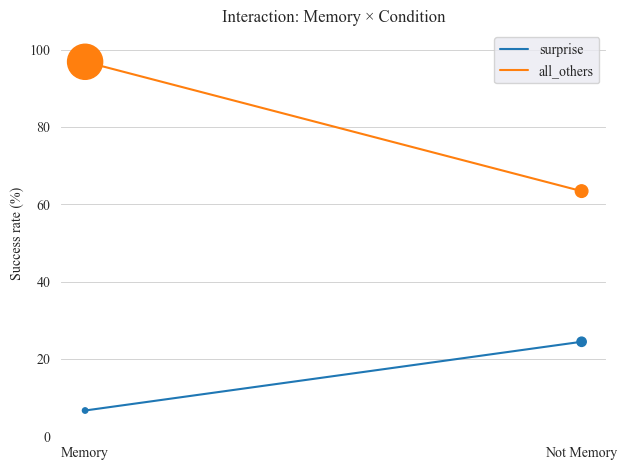

In [48]:
interaction_plot(first_irrel, rest_df)

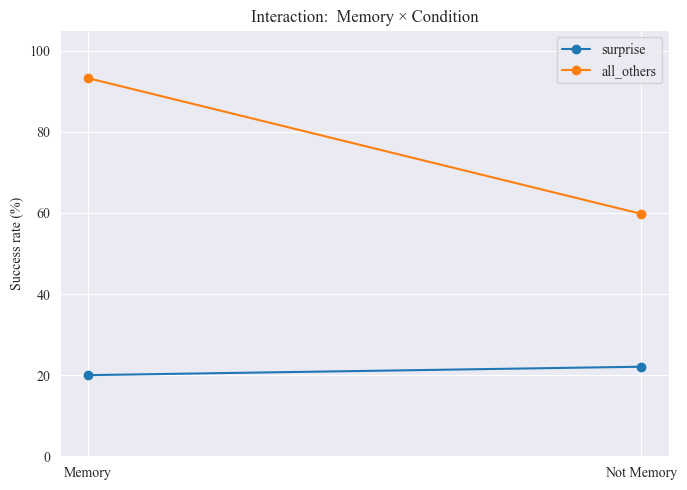

In [59]:
interaction_plot(both_experiments_sup, rest_df)